<a href="https://colab.research.google.com/github/michielva/binance-spot-api-docs/blob/master/Second_graded_assignment_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second graded assignment: convolutional neural networks

## 1. Imports, Drive mounting, helper function(s)

In [1]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import os

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

2.4.1


In [2]:
# uncomment if you want to use Drive

from google.colab import drive
drive.mount('/content/gdrive')


!ls '/content/gdrive/My Drive/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
'BUCKET LIST.gdoc'    'Colab Notebooks'     'ENGELSTRAAT 144'  'THESIS MASTAT'
'BUSINESS ECONOMICS'  'Deep Learning 2021'  'Financieel Huis'   TRAVEL


In [3]:
#helper functions for visualisation

# same function as before - feel free to customize if you want!

def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.ylim([0.0,1.0])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()

## 2. Assignment overview

Since we have now definitely concluded that MNIST is too easy, we will move to a slightly more difficult data set to play with. It is called CIFAR100 (https://www.cs.toronto.edu/~kriz/cifar.html) and contains (still TINY) natural images of objects in 20 different classes, each with 5 sub-classes (100 classes in total).

To make the problem slightly easier, we will only use the coarse differentiation into 20 classes.

The code below shows a simple example of a convolutional neural network. Your first task is to try and understand the layers and their parameters, using the Tensorflow-Keras documentation. Then start to optimise the network, using the same steps as in the first graded assignment: (i) find an unregularised network that is powerful enough to overfit on the training set (note that this tast is harder, so you can tolerate slightly less fast-and-perfect learning as in the first graded assignment); (ii) regularise; (iii) iterate to improve. You can now also use the new things we discussed in the last lecture. Since the number of options is very large, try to take inspiration from what other people did (and mention your sources).

Note that augmentation dramatically slows down the learning process. For this reason, it is typically added after you already have a promising solution, i.e., a network that is tuned without augmentation, but for which you have good indications that more data would help. 

In order to pass for this assignment, you need to submit at least one properly tuned network, with a documentation of how you got there and a decent analysis of the performance of your network and the errors it still makes. The new components to be used in this assignment (compared to the first) are: **convolutional layers**, **batchnorm** and **augmentation**. To get really high grades, report on more than one approach, and/or try to reproduce something more advanced (from literature or online sources - mention your references), e.g., ResNet or DenseNet.

**It is not allowed to use pre-trained networks for this assignment!!**





## Loading the data

In the code below, we load the data. The option 'coarse' selects the 20-class version (instead of the 100-class version).

This code is mostly re-used from the first assignment. 

In [4]:
# Load the data: CIFAR100 with 20 class labels
(x_train_all, r_train_all_class), ( _ , _ ) = cifar100.load_data(label_mode='coarse')

num_classes = 20

val_size = 6000
# make validation set
x_train, x_val, r_train_class, r_val_class = train_test_split(x_train_all, r_train_all_class, test_size=val_size, random_state=0)

# let's again take a subset of the training data first, for playing around
# Note that such a subset is only useful if it can guide your tuning process,
# i.e., if it leads you to similar decisions as you would make on the whole training set

# You can again use a subset of the training data for initial exploration
# In this case, 10000 samples is really too small, so we suggest 20000

x_train_small = x_train[:20000]
r_train_small_class = r_train_class[:20000]

# And we do the same standardization as in the first assignment
x_train_all = x_train_all.astype('float32')
x_train = x_train.astype('float32')
x_train_small = x_train_small.astype('float32')
x_val = x_val.astype('float32')

x_train_all /= 255.0
x_train /= 255.0
x_train_small /= 255.0
x_val /= 255.0

# the labels from the downloaded data are integer numbers
# for a multi-class classification task, we again convert each integer
# to a vector with 19 zeros and a single '1', corresponding to the right class
r_train_all = tf.keras.utils.to_categorical(r_train_all_class, num_classes)
r_train = tf.keras.utils.to_categorical(r_train_class, num_classes)
r_train_small = tf.keras.utils.to_categorical(r_train_small_class, num_classes)
r_val = tf.keras.utils.to_categorical(r_val_class, num_classes)


# Labels
labels = [
'aquatic mammals',
'fish',
'flowers',
'food containers',
'fruit and vegetables',
'household electrical devices',
'household furniture',
'insects',
'large carnivores',
'large man-made outdoor things',
'large natural outdoor scenes',
'large omnivores and herbivores',
'medium-sized mammals',
'non-insect invertebrates',
'people',
'reptiles',
'small mammals',
'trees',
'vehicles 1',
'vehicles 2'
]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')



x_train shape: (44000, 32, 32, 3)
44000 train samples
6000 validation samples


Note the shape of the training data. In the previous assignment, we had grayscale images, consisting of 28x28 pixels. As we were using Dense networks then, we flattened the pixels into a single vector per image. We will now be using convolutional networks, which means we need to keep all pixel values in 2D arrays.

In addition, in the current assignment, the data consists of **colour** images, which means that each image consists of 3 arrays of pixels (RGB: red, green, blue). Every sample is now a tensor of 32x32x3 numbers. 

It is a general agreement that the **first** dimension of the training data always reflects the number of samples and all other dimensions are the sample dimensions. Hence, our complete training set is a tensor of shape (44000, 32, 32, 3). When training with batches, each batch will be a tensor of shape (batch_size, 32, 32, 3).

The images are very low resolution, to the extent where it is often even hard for humans to recognise what is on them. Considering that there are less training samples than in the first assignment, that there are twice as many classes and the data is more complex, it is clear that this task is a lot more difficult. Below are a few examples of the training data:



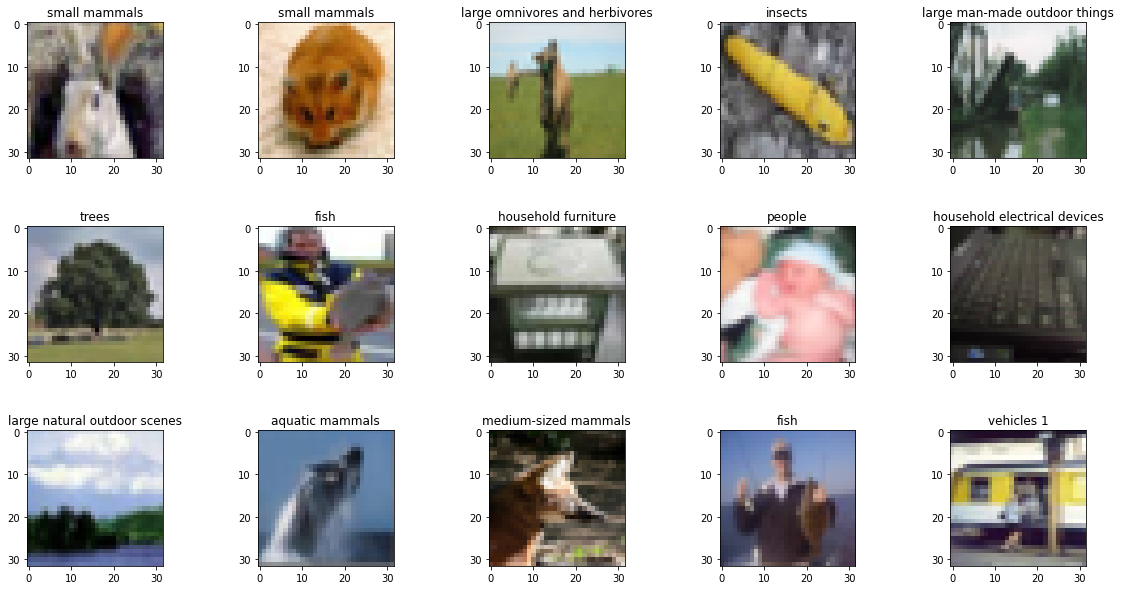

In [5]:
f = plt.figure(figsize=(20,10))
for idx in range(15):
    plt.subplot(3,5,idx+1)
    plt.subplots_adjust(hspace=0.5)
    plt.title(labels[r_train_class[idx,0]])
    plt.imshow(x_train[idx],  interpolation='None')

# An initial model to show how it's done

The code below shows a simple example of a convolutional neural network.

In [6]:
'''Train a simple CNN on the CIFAR100 small images dataset.
Initial model based on example networks used for CIFAR10
e.g., https://keras.io/examples/cifar10_cnn/
'''

# Recall the two main structural paramameters of a network: layer width and network depth
#
# - Layer width determines how many "different things" can be extracted by a layer. 
# - depth determines the complexity of the features that can be extracted

# In convnets, layers are often organised in blocks of layers with the same width, 
# followed by a pooling step to reduce the layer size
# This again allows more complex features to be extracted between pooling steps 

# The first conv layers have 32 filters (channels) with filter size 3x3
# note that this has no relation with the image size, which just happens to be 32x32 pixels!

def initial_model():
  model = Sequential()
  # Convolutional layers
  model.add(Conv2D(128, (3, 3), padding='same',
        input_shape=x_train.shape[1:],kernel_constraint=max_norm(4)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(128, (3, 3),padding='same',kernel_constraint=max_norm(4)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(256, (3, 3), padding='same',kernel_constraint=max_norm(4)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(256, (3, 3), padding='same',kernel_constraint=max_norm(4)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_constraint=max_norm(4)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(512, (3, 3),padding='same',kernel_constraint=max_norm(4)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  # end of convolutional layers, start of 'hidden' dense layers
  model.add(Flatten())
  model.add(Dense(1024,kernel_constraint=max_norm(4)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  # model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(BatchNormalization())
  model.add(Activation('softmax'))

  opt = tf.keras.optimizers.Adam(learning_rate=0.00003) 

  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

  return model

Some information about the model code:

- Just like for the Dense network, the input shape must be specified in the first layer. Where this was only a single number (the number of features) previously, it is now the dimension of a single training sample, so (32,32,3). The Conv2D layer expects a stack of 2D arrays as input. The first two dimensions of the input shape are the dimensions of these arrays, the third dimension is the number of 'channels' (see theory).
- Padding (same) is used here for all conv layers. This is quite standard and avoids you having to keep track of channel shapes (input and output channels of conv layers are equal if padding is used).
- As pooling reduces the size of each channel, it is common to increase the number of filters throughout the layers. This way spatial features (things you see on the image) are gradually translated into abstract features (concepts that are useful to make the classification).
- The code also shows a common practice of combining a few conv layers with the same dimensions before pooling. Note that this is not necessary, it's just how it is often done.
- If you use batchnorm, it is generally advised to put it **before** the activation, i.e., between the convolution and the ReLu (or other) nonlinearity. This is not possible if you specify the nonlinearity as a parameter of the conv layer. We have therefore split it off as a separate layer in the code above.
- Dropout is typically applied on the inputs of a layer, i.e., **after** the nonlinearity of the previous layer (see commented examples). Typically, the more parameters a layer has, the more dropout you will be able to use.
- After the last conv layer, you need to reshape all the remaining features into a single vector again, such that they can be input into the Dense layer(s). This is what the 'Flatten()' layer does - an alternative is to combine the last pooling layer and the Flatten layer into a global pooling layer, which retains only one feature per channel (Max or Average, see docs for more info).

In [ ]:
batch_size = 1024
epochs = 400

# checkpoint and early stopping code from first assignment is introduced in comments:
# use or replace by your preferred workflow 
# do not forget to reload best model for evaluation after using early stopping (re-use code from first assignment)

checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/model_before_aug/"
print("Models will be saved in ",checkpoint_dir)
model_savename = checkpoint_dir+"best_model.1.h5"
checkpoint_path = checkpoint_dir+"cp-{epoch:04d}.ckpt"


model_1 = initial_model()
model_1.summary()

# code for modelcheckpoint and early stopping  commented below
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 monitor='val_accuracy',
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)
stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30,min_delta=0.0001)

history_1 = model_1.fit(x_train, r_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, r_val),
          callbacks = [cp_callback,stopping_callback],
          shuffle=True)

# Run code below to save the weights of final trained model:
# (not very useful in combination with modelcheckpoint, because then you would revert to the best model afterwards)
#model_1.save_weights(model_savename)

# We analyse the result:

[train_loss, train_accuracy] = model_1.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = model_1.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.2f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))

#Now we visualise what happened during training
plot_history(history_1)

Models will be saved in  /content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/model_before_aug/
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 128)       0         
___________________________

We can see that it is not sufficiently powerful and heavily overfitting!

One thing to note is that there are a **huge** number of parameters in the first Dense layer!! This is not surprising, since it has > 4000 input features. Conv layers have far fewer features. The ideal way to avoid the explosion of parameters in the first Dense layer is therefore to take conv layers + pooling much further, such that the number of features per channel gets down to 2x2 or even 1x1 before calling flatten(). As stated before, you can also shortcut a few levels by using global pooling.

Use dropout mainly in (large) dense layers, i.e., the dense layers with most weights. Be careful with dropout in the output layer since that normally does not have too many weights. Whether or not it's useful to add dropout on conv layers again depends on the number of parameters they have. Adding too much dropout anywhere will generally make results worse. Introducting dropout in dense and conv layers at the same time is not advised: it may lead you to the wrong conclusions, since they may have opposite effects. As always: change one thing at the time in order to be able to draw clear conclusions.

As you make your network deeper (which you definitely should), you will increasingly run into 'vanishing gradients' (not the 'decreasing derivatives' part but the 'decreasing precision' part). If you have vanishing gradients, gradient descent will not allow you to fully exploit the power of your model. The first step of "making your network powerful enough" will therefore not succeed as well as you would hope!

One of the first things you should do if you want to make deeper networks is therefore counteract vanishing gradients by introducing batchnormalisation (or later: adding skip-connections, see, e.g., https://keras.io/examples/cifar10_resnet/ - note that this requires some more advanced coding!). You can introduce batchnormalisation after each layer. Since batchnorm also acts as a regulariser (see theory), you may also see a decrease in overfitting. A final hint: batchnorm tends to combine well with maxnorm (and dropout, obviously).

In practice, batchnorm is often introduced from the beginning, i.e. in the stage of "making your network powerful enough", since it is often the only way to properly explore the power of deeper networks.

The steps you should take to tune your network are similar to the first assignment. However, since the number of options has increased dramatically, it is a good idea to have a look at literature or online examples first. You won't find many results on the 'coarse' version of CIFAR100, but you can use networks used on the same data (with the full 100 classes) or even networks used on the simpler CIFAR10 (similar data, but only 10 classes) as inspiration.



## 3. Augmentation

When using data augmentation on large data sets, it is not feasible to generate the augmented samples up-front. Instead, they are generated 'on the fly' when reading in batches: before each training sample is used in a batch, it is first augmented, so each time the same original sample is used, its augmented version is different. This is done using an ImageDataGenerator.

Before actually using augmentation, it is usually a good idea to have a look at some augmented images. The code block below shows how you can do this.

In [13]:
# Save best model checkpoint

import pathlib

# Sort the checkpoints by modification time.
checkpoints = pathlib.Path(checkpoint_dir).glob("*.index")
checkpoints = sorted(checkpoints, key=lambda cp:cp.stat().st_mtime)
checkpoints = [cp.with_suffix('') for cp in checkpoints]
latest = str(checkpoints[-1])
print(latest)
checkpoints

best_model_1 = initial_model() # this is a new model
best_model_1.load_weights(latest)

# The code below should give slightly better results than that for the original model
[train_loss, train_accuracy] = best_model_1.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_accuracy] = best_model_1.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

model_savename_best = checkpoint_dir+"model_1024_best.1.h5"
best_model_1.save_weights(model_savename_best)

/content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/model_before_aug/cp-0274.ckpt
Training set Accuracy: 0.7127
Training set Loss:1.016794

Validation set Accuracy: 0.5925
Validation set Loss:1.374719



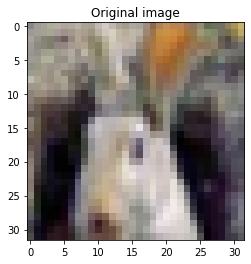

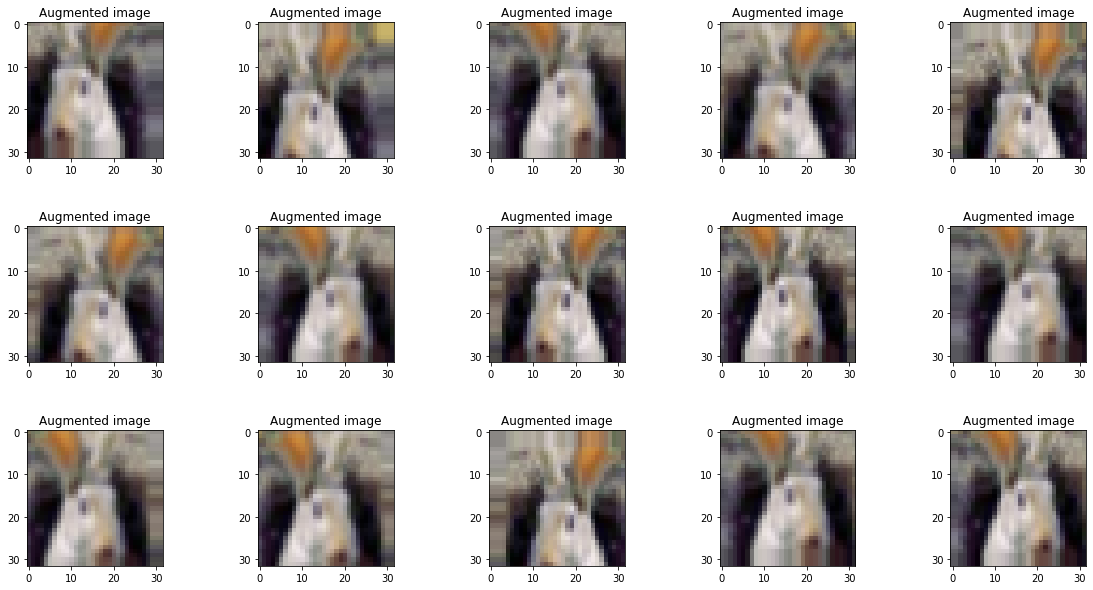

In [16]:
# An object from the class ImageDataGenerator will do 'on-the-fly' data augmentation
# every time you call its function .flow()

# Note that not all options are used here: check the docs for additional info
# the class also contains a 'hook' for adding your own augmentation functions

datagen = ImageDataGenerator(
        rotation_range=0.0,       # randomly rotate images in the range (degrees, 0 to 180) - note that rotation is more compute-intensive than shifting!!
        width_shift_range=0.05,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.05,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,     # randomly flip images
        vertical_flip=False,      # randomly flip images
        fill_mode = 'nearest',    # what to do with 'new' pixels that occur as the result of a transformation
        zoom_range = 0)  

# select and show an image from the training set
img_index = 0

plt.figure()
plt.imshow(x_train[img_index],  interpolation='None')
plt.title("Original image")
plt.show()

testit = datagen.flow(x_train[img_index:img_index+1], batch_size=1)

# generate 15 augmented images (the first one is the original image)
f = plt.figure(figsize=(20,10))
for idx in range(15):
    plt.subplot(3,5,idx+1)
    plt.subplots_adjust(hspace=0.5)
    plt.title("Augmented image")
    plt.imshow(testit.next()[0,:,:,:],  interpolation='None')
plt.show()



Use the code above to decide how much augmentation you can allow while still getting 'realistic' images, i.e., images you would want your network to be able to classify. Remember that adding more extreme augmentation makes your task harder, while using too little augmentation will barely have an effect and only slow down your training. Try to aim for the point where you see that augmented images look sufficiently different but still realistic.

**Large data sets (advanced):**
The data set in this assignment is small enough to fit in memory so we can use the example code provided here. For realistic image data sets, this is usually not the case. This is also solved by using an ImageDataGenerator object, but now using the iterator 'flow_from_directory()'. In that case, batches are made by reading each sample from disk and transforming it as needed (preprocessing and/or augmentation). Now, only your batch needs to fit in memory (and your network, of course). This is explained in [this tf Keras example notebook](https://www.tensorflow.org/tutorials/images/classification). Note that this implies that the rescaling we did at the beginning of this notebook will also be done by the ImageDataGenerator class. You would need to make two such classes: one for training (with augmentation, if you want that) and one for validation (without augmentation), since they would now read from different paths.  

**Using augmentation in model training**:
In the code block below, you can see how you can compile and train the same model with data augmentation. It also includes early stopping. 

You wil notice that training now takes longer because of the image preprocessing (augmentation) that is required!

For this reason it is advisable to first tune your network without augmentation. You want to get into a regime where you are still overfitting and you have a clear indication that more data would help, for example by comparing training and validation scores for two training set sizes (e.i., two points of a learning curve), or when you find that considerable overfitting remains, but adding any other type of regularisation makes validation performance worse. 

Then, check which types and levels of augmentation actually help by switching back to the small data set (comparing train and validation scores for unaugmented training and augmented training, where everything else is kept constant). Since this is rough exploration, you can also save time by setting your patience values a bit lower. Once you think you have good augmentation settings, switch back to the larger training set an do a full-blown training run.

**Warning** running the code below takes considerably longer!!


In [23]:
batch_size = 1024
epochs = 400

au_model = initial_model()
au_model.summary()
au_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# dummy file path here ... this is local on Colab!
filepath = 'save_my_au_model.h5'

callbacks = [EarlyStopping(monitor='val_accuracy', patience=30),
             ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)]

datagen = ImageDataGenerator(
        rotation_range=0.0,  # randomly rotate images in the range (degrees, 0 to 180) - note that rotation is more compute-intensive than shifting!!
        width_shift_range=0.05,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.05,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        fill_mode = 'nearest', # what to do with 'new' pixels that occur as the result of a transformation
        zoom_range = 0.0)  

# Compute quantities required for some augmentation functions
# (e.g., std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train, augment=True)

# Fit the model on the batches generated by datagen.flow().
au_history = au_model.fit(datagen.flow(x_train, r_train, batch_size=batch_size),
                                    epochs=epochs, steps_per_epoch=len(x_train) / batch_size,
                                    validation_data=(x_val, r_val),
                                    callbacks = callbacks)



# Note: you can totally ignore the warning you get:
# WARNING:tensorflow:sample_weight modes were coerced from ... to ['...']
# this appears to be a bug in tf 2.1


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_64 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
activation_64 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 30, 30, 128)       147584    
_________________________________________________________________
batch_normalization_65 (Batc (None, 30, 30, 128)       512       
_________________________________________________________________
activation_65 (Activation)   (None, 30, 30, 128)       0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 15, 15, 128)      

KeyboardInterrupt: ignored

By running the code below, you can compare the situation with and without augmentation (or any two situations ...). 

In this case, we can conclude that augmentation managed to reduced most of the overfitting, but it did not fundamentally improve validation accuracy. The main reason for this is probably that the network is nowhere close to decent yet: remember that **augmentation can help reduce overfitting**. However, this can only improve validation accuracy if the model has low enough bias. In this case, bias is still way too high!

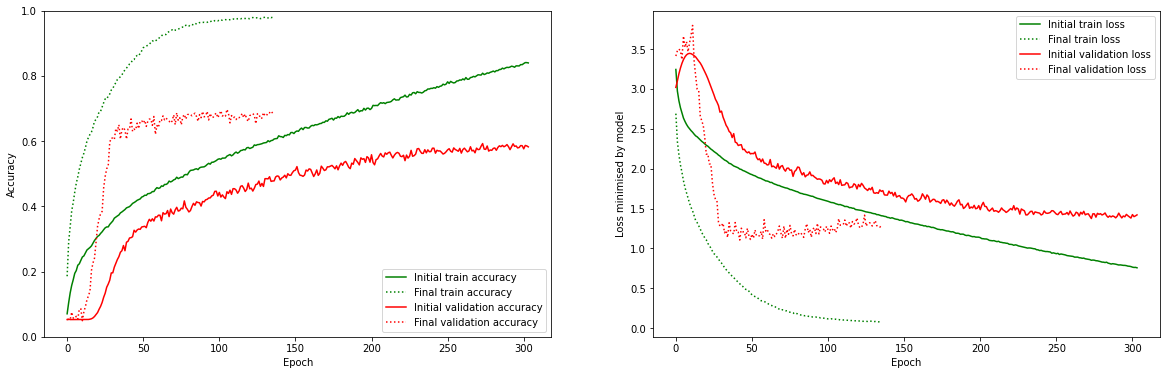

In [22]:
def plot_dual_history(before,after):
  plt.figure(figsize = (20,6))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(before.epoch, np.array(before.history['accuracy']),'g-',
           label='Initial train accuracy')
  plt.plot(after.epoch, np.array(after.history['accuracy']),'g:',
           label='Final train accuracy')
  plt.plot(before.epoch, np.array(before.history['val_accuracy']),'r-',
           label = 'Initial validation accuracy')
  plt.plot(after.epoch, np.array(after.history['val_accuracy']),'r:',
           label = 'Final validation accuracy')
  plt.ylim([0.0,1.0])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(before.epoch, np.array(before.history['loss']),'g-',
           label='Initial train loss')
  plt.plot(after.epoch, np.array(after.history['loss']),'g:',
           label='Final train loss')
  plt.plot(before.epoch, np.array(before.history['val_loss']),'r-',
           label = 'Initial validation loss')
  plt.plot(after.epoch, np.array(after.history['val_loss']),'r:',
           label = 'Final validation loss')
  plt.legend()


plot_dual_history(history_1,au_history)


## Now it's your turn again
Make a new notebook in which you use the code examples in this notebook to train your own network. Obviously, you are allowed to add code of your own.
Please make sure that the final model notebooks you hand in **only contain necessary code and explanation blocks.** 

**How good should you get?** Without advanced techniques (such as skip connections), you should be able to get beyond 72% validation accuracy (using 44000 training samples). 

Now the floor is yours. Don't forget to re-train your final model(s) on all the original training data (x_train_all, r_train_all) and saving your best model for evaluation. After that: use the same analyses as in the first graded assignment for discussing the results of your best model(s).
